# OCR API를 이용한 문자인식 예제

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; '지면 신문 OCR 인식', '식품 원재료명 OCR 인식'이 필요한 상황을 가정하고 'Keras OCR'과 'Tesseract OCR'의 성능 테스트 및 평가를 시행하였다.  지면 신문 OCR 인식의 경우, 지면 신문의 기사 헤드라인 이미지로부터 내용을 추출하는 작업을 시행하였으며 평가 기준으로 전체 단어 중 올바르게 인식한 단어의 비중을 사용하였다. 헤드라인 세 개의 문장을 이용하였으며, 총 단어 수는 28개로 Keras OCR의 경우 28개를 올바르게 인식하여 정확도 1.였고 Tesseract OCR의 경우 8개를 올바르게 인식하여 정확도 0.348에 해당하였다. 또한, 단어를 올바른 순서로 배치하기 위해 각 단어의 좌표를 바탕으로 선형변환을 시행하였다. 식품 원재료명 OCR 인식의 경우, 과자 프링글스의 원재료명 이미지로부터 원재료 단어를 추출하는 작업을 시행하였으며 평가 기준으로 전체 단어 중 올바르게 인식한 단어의 비중을 사용하였다. 총 단어 수는 77개로 Keras OCR의 경우 60개를 올바르게 인식하여 정확도가 0.779였고 Tesseract OCR의 경우 33개를 올바르게 인식하여 정확도가 0.429로 Keras OCR이 더 정확하였다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제는 문자 인식이 필요한 상황을 가정하고 이를 Keras OCR과 Tesseract OCR를 사용하여 테스트 및 평가를 진행합니다. 상황은 '지면 신문 OCR 인식'과 '식품 원재료명 OCR 인식'으로 가정하여 예제를 진행 합니다. 상황 가정 이후에는 사용되는 데이터의 특성에 따라 평가 기준을 설정하고 각 OCR API를 테스트 한 후, 최종적으로 기준에 따라 평가합니다. 다음은 예제의 진행 순서를 제시한 것입니다.
</span><br><br>


> _1. 상황 가정_
>
> _2. 평가기준 설정_
>
> _3. OCR API 테스트_
>
> _4. OCR API 평가_


***

#### 필요 라이브러리 호출
***
+ 예제에 사용할 라이브러리를 호출합니다.
***

In [1]:
import os   #디렉토리 관리
import numpy as np   #행렬 연산
from PIL import Image   #이미지 불러오기

import matplotlib.pyplot as plt   #이미지 시각화
import matplotlib.image as mpimg   #이미지 불러오기

import keras_ocr   #Keras OCR
pipeline = keras_ocr.pipeline.Pipeline()   #Pipeline

import pytesseract   #테서렉트
from pytesseract import Output   #테서렉트

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


<br>

## 2. 상황 1: 지면 신문 OCR 인식
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; A씨는 자동 주식 매매 시스템을 개발하고 있습니다. 그는 새로운 매매 기준을 고민하고 있는데, '국가 정세'가 코스피와 같은 주가 지수에 영향을 미칠 것이라 생각했습니다. 이에 국가 정세를 '긍정'과 '부정'으로 구분하고 그에 따른 주가 지수의 변화를 확인하려합니다. 그래서 그는 '국가 정세'의 긍정 및 부정에 대한 지표로 '지면 신문'의 내용을 이용하고자 합니다. 긍정적인 기사가 많다면 주가 지수가 상승할 것이고 반대로 부정적인 기사가 많다면 주가 지수가 하락할 것이라 예상하는 것입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; A씨는 우선 지면 신문의 기사 헤드라인 이미지로부터 내용을 추출하는 작업을 하려고 합니다. 헤드라인이 곧 기사의 내용을 요약한 것이므로 헤드라인만 이용하고자 하는 것입니다. 이미지로부터 문자를 추출하기 위해 'Keras OCR'과 'Tesseract OCR' 중 하나를 이용하고자 합니다. 따라서, 평가기준을 설정하고 이에 부합하는 OCR 모델을 채택 합니다.
</span>

***

### 2.1. 평가기준 설정
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델의 평가기준으로 인식 정확도를 이용합니다. 단어를 기준으로 올바르게 인식하는 정도를 파악 합니다. 따라서 맞춘 단어 수를 테스트 단어 수로 나누어 정확도를 구하고자 합니다. 다음은 정확도의 수식을 제시한 것입니다.
</span><br><br>

$$Accuracy = \frac{Correct Word Num}{Word Num}$$

<br><span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 또한, 헤드라인을 순차적으로 입력하여 긍, 부정을 분류해야합니다. 때문에 인식 결과의 좌표를 받을 수 있거나 왼쪽에서 오른쪽으로 단어가 순차적으로 인식될 필요가 있습니다.
</span><br><br>

***

### 2.2. 테스트 데이터
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 테스트 데이터로 'Korea JoonAng Daily'의 2021년 11월 27일 1면의 헤드라인을 사용합니다. 헤드라인은 총 세 개이며, 'Base rate goes up with inflation prediction', 'Legislators kick the can on exemptions for BTS', 'New infections, critically ill remain at high 'levels' 입니다. 지면 신문의 경우 손글씨와 비교하였을 때, 글씨체와 간격이 일정하기 때문에 인식이 비교적 쉬울 것으로 예상됩니다. [그림 1]은 Korea JoongAng Daily'의 2021년 11월 26일의 1면을 제시한 것입니다.
</span><br><br>

<img src="./img/1126.jpg" width=400>

[그림 1] Korea JoongAng Daily 2021-11-26, https://www.joins.com/Media/List.aspx?mseq=15

***

#### 헤드라인 이미지 시각화
***
+ 신문의 각 헤드라인 이미지를 시각화 합니다.
***

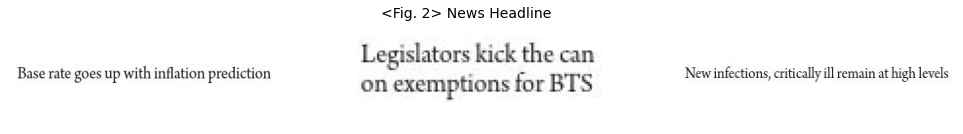

In [2]:
image_path_list = [
    "./dataset/paper_1.png",
    "./dataset/paper_2.png",
    "./dataset/paper_3.png"
]

images = [mpimg.imread(img_path) for img_path in image_path_list]


plt.figure(figsize=(17, 2))
plt.suptitle("<Fig. 2> News Headline", fontsize=14)
for idx, img in enumerate(images):
    plt.subplot(1, 3, 1+idx)
    plt.axis("off")
    plt.imshow(images[idx])
plt.show()

<br>

### 2.3. Keras OCR 테스트
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Keras OCR을 이용하여 신문 기사의 헤드라인을 인식 합니다. 앞서 제시한 바와 같이 헤드라인은 총 세 개로 'Base rate goes up with inflation prediction',  'Legislators kick the can on exemptions for BTS', 'New infections, critically ill remain at high 'levels' 입니다. Keras OCR의 인식 결과를 확인한 바, 모든 단어에 대해 올바르게 인식하였습니다. 따라서, 평가지표로 선택한 Accuracy는 1. 입니다.
</span><br><br>
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 한 가지 문제가 있는데, 인식한 단어가 문장의 순서대로 기록되지 않습니다. 문장을 입력하여 긍, 부정을 판단할 것이기 때문에 단어를 순서대로 위치시킬 필요가 있습니다. Keras OCR은 단어의 좌표를 하기 때문에 이를 바탕으로 단어의 순서를 복원할 필요가 있습니다.
</span>

***

#### Keras OCR 인식 시각화
***
+ 헤드라인 이미지에 대한 Keras OCR의 인식 결과를 시각화 합니다.
***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


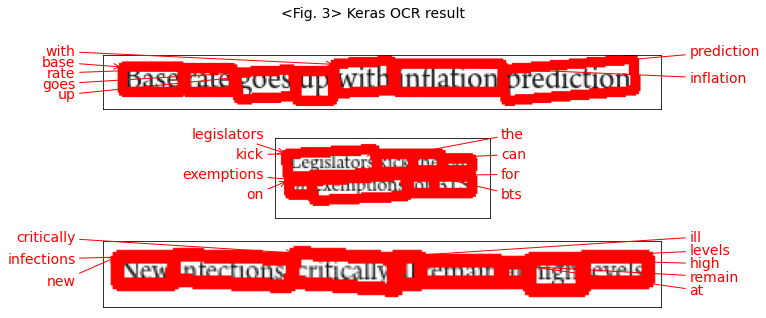

In [4]:
prediction_groups = pipeline.recognize(image_path_list)

fig, axs = plt.subplots(nrows=3, figsize=(10, 5))
plt.suptitle("<Fig. 3> Keras OCR result", fontsize=14)
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx], ax=ax)
plt.show()

<br>

### 2.3. 단어 순서 복원
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 단어의 좌표를 바탕으로 순서를 재배치 시키고자 합니다. [그림 4]는 문장 'Legislators kick the can on exemptions for BTS'를 바탕으로 한 단어 순서 복원 순서를 제시한 것입니다. 기본적인 아이디어는 (0, 0) 위치에서 단어가 떨어진 정도를 기반으로 순서를 정하는 것입니다. 우리는 글을 읽을 때, 위쪽에서 아래로, 왼쪽에서 오른쪽으로 글을 읽습니다. (0, 0)은 좌상단에 해당한다고 볼 수 있습니다. 첫번째 줄에 해당하는 'Legislators', 'kick', 'the', 'can' 순으로 거리가 가깝습니다. 따라서, 그 순서대로 단어를 배치시키면 될 것같습니다. 그런데, 두번째 줄의 'on', 'exemptions' 단어가 첫번째 줄 마지막 단어인 'can' 보다 가깝습니다. 만약 이대로 순서를 배치시킨다면 'Legislators on kick exemptions the for can BTS'이 됩니다. 따라서, 두번째 줄 단어를 'can' 보다 멀리 위치시킬 필요가 있습니다.
</span><br><br>
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
이를 해결하기 위해 선형대수 관점에서 선형변환을 통해 두번째 줄의 단어들을 shear 하여 줍니다. 이를 통해 두번째 줄의 단어들이 'can' 보다 멀리 위치하게 되고 최종적으로  'Legislators kick the can on exemptions for BTS'로 올바른 순서로 단어를 배치시킬 수 있습니다.
</span>

<img src="./img/shear.png" width=600>

[그림 4] 선형변환을 통한 단어 순서 복원

***

#### Keras OCR 인식 단어 및 좌표 획득
***
+ Keras OCR이 인식한 단어와 각 단어의 좌표를 획득합니다.
***

In [5]:
prediction_groups = pipeline.recognize(image_path_list)

sentences, xy_list, letter_y, letter_size = [], [], [], []
for sentence in prediction_groups:
    words, x_s, y_s = [], [], []
    letter_y_ = sentence[0][1][0][1]
    
    letter_y.append(letter_y_)
    letter_size.append(sentence[0][1][2][1] - letter_y_)
    
    for word, location in sentence:
        words.append(word)
        x_s.append(location[0][0].tolist())
        y_s.append(location[0][1].tolist())
    sentences.append(words)
    xy_list.append([x_s, y_s])

<br>

#### Keras OCR 인식 단어 확인하기
***
+ Keras OCR이 인식한 단어의 순서가 올바르지 않음을 확인할 수 있습니다.
***

In [6]:
sentences

[['with', 'inflation', 'base', 'prediction', 'rate', 'goes', 'up'],
 ['legislators', 'kick', 'the', 'can', 'for', 'bts', 'exemptions', 'on'],
 ['new', 'infections', 'ill', 'levels', 'critically', 'high', 'remain', 'at']]

<br>

#### 단어 순서 복원 하기
***
+ 선형대수의 관점에서 단어의 좌표를 이용하여 단어 순서를 복원 합니다.
***

In [7]:
sorted_sentences = []
for sentence, letterY, letterSize, (x, y) in zip(
    sentences, letter_y, letter_size, xy_list
):
    x, y = np.array(x), np.array(y)

    x_norm = (x - min(x)) / (max(x) - min(x))
    y_norm = ((y - letterY) / letterSize) ** 2
    
    xy_arr = np.array((x_norm, y_norm))
    shear = ((3, 2), (0, 1))

    xy_arr = np.matmul(shear, xy_arr)
    xy_arr = xy_arr ** 2
    xy_arr = xy_arr[0] + xy_arr[1]

    sort = np.argsort(xy_arr)

    sorted_sentence = np.array(sentence)[sort]
    sorted_sentences.append(sorted_sentence)

<br>

#### 단어 순서가 복원된 문장 확인
***
+ 순서가 복원된 문장을 확인 합니다.
***

In [8]:
for sentence in sorted_sentences:
    print(sentence.tolist())

['base', 'rate', 'goes', 'up', 'with', 'inflation', 'prediction']
['legislators', 'kick', 'the', 'can', 'on', 'exemptions', 'for', 'bts']
['new', 'infections', 'critically', 'ill', 'remain', 'at', 'high', 'levels']


<br>

### 2.4. Tesseract OCR 테스트
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; <span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Tesseract OCR을 이용하여 신문 기사의 헤드라인을 인식 합니다. 앞서 제시한 바와 같이 헤드라인은 총 세 개 입니다. Tesseract OCR의 인식 결과를 확인한 바, 8개의 단어에 대해 올바르게 인식하였습니다. 총 단어의 수는 23개로, 평가지표로 선택한 Accuracy는 0.348 입니다.
</span>

***

#### 필요 함수 정의
***
+ Tesseract OCR을 이용하기 위한 함수를 정의 합니다.
***

In [9]:
#단어 기준 이미지 자르기 함수=================
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list
#End==========================================


#단어 인식 함수===============================
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    sentence = []
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(  #검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나온다.
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        sentence.append(recognized_data['text'].replace("\n\x0c", ""))
    
    return sentence
#End==========================================

<br>

#### Tesseract OCR 인식 단어 확인하기
***
+ Tesseract OCR이 인식한 단어를 확인합니다.
***

In [10]:
for path in image_path_list:
    cropped_image_path_list = crop_word_regions(path)
    sentence = recognize_images(cropped_image_path_list)
    print(sentence)

['Bas', 'erate', 'KOCS', 'Up', 'wit', 'h inflation', 'prediction']
['Legislators', 'cick', 'the', ', ah dD', '_ 2', 'n exemption', '© tor', 'BLS']
['New', 'intections', ', critically', 'tt', 'reTTialt', 'wit', 'high', 'levels']


<br>

### 2.5. API 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Keras OCR과 Tesseract OCR의 인식 결과를 바탕으로 평가하고자 합니다. 전체 단어 수는 28개로 Keras OCR의 경우 올바르게 인식한 단어 수가 28개, Tesseract OCR의 경우 8개 입니다. 따라서, Keras OCR의 인식률이 더 높다고 할 수 있습니다.
</span>

|Model|Word Num|Correct Word Num|Accuracy|
|:--------:|:--------:|:--------:|:--------:|
|**Keras OCR**|28|28|**1.**|
|**Tesseract OCR**|28|8|0.348|

***

<br>

## 3. 상황 2: 식품 원재료명 OCR 인식
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; B씨는 식품 원재료명을 촬영하면 알레르기 유발 물질 리스트를 출력하는 서비스를 제공하고자 합니다. 따라서 가장 먼저 식품 원재료명 이미지로부터 단어를 인식하는 작업을 수행하려 합니다. OCR 인식 API인 'Keras OCR'과 'Tesseract OCR' 중 하나를 채택하고자 합니다.
</span>

***

### 3.1. 평가기준 설정
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델의 평가기준으로 인식 정확도를 이용합니다. 단어를 기준으로 올바르게 인식하는 정도를 파악 합니다. 따라서 맞춘 단어 수를 테스트 단어 수로 나누어 정확도를 구하고자 합니다. 다음은 정확도의 수식을 제시한 것입니다.
</span><br><br>

$$Accuracy = \frac{Correct Word Num}{Word Num}$$

***

### 3.2. 테스트 데이터
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 과자 '프링글스'의 원재료명 이미지를 테스트 데이터로 사용합니다. [그림 5]는 프링글스의 원재료명 이미지 입니다. 손글씨와 비교하였을 때, 글씨체와 간격이 일정하기 때문에 인식이 비교적 쉬울 것으로 예상됩니다. 총 단어의 수는 77개 입니다. 앞서 진행한 신문 헤드라인 인식 예제와는 다르게 단어의 순서는 중요하지 않습니다.
</span><br><br>

<img src="./img/pring.png" width=500>

[그림 5] Pringles Ingredient List

***

<br>

### 3.3. Keras OCR 테스트
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Keras OCR을 이용하여 프링글스의 원재료명 이미지를 인식 합니다. 총 단어의 수는 77개 입니다. Keras OCR의 인식 결과를 확인한 바, 60개의 단어를 올바르게 인식하였습니다. 따라서, 평가지표로 선택한 Accuracy는 0.779 입니다. 올바르게 인식하지 못한 문자는 Maltodextrin, cumin 등으로 대부분 괄호를 'I'로 인식하여 'imaltodextrin', 'cuminl'으로 출력하였습니다.
</span>

***

#### Keras OCR 인식 시각화
***
+ 원재료명에 대한 Keras OCR의 인식 결과를 시각화 합니다.
***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


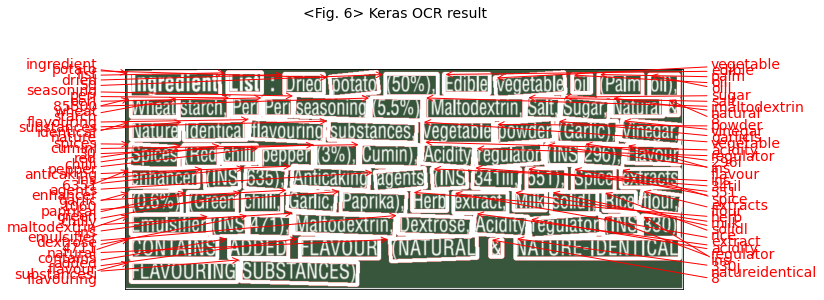

In [16]:
image_path_list = ["./dataset/pring.png"]
images = [mpimg.imread(img_path) for img_path in image_path_list]

prediction_groups = pipeline.recognize(image_path_list)

fig, axs = plt.subplots(nrows=1, figsize=(10, 5))
plt.suptitle("<Fig. 6> Keras OCR result", fontsize=14)
keras_ocr.tools.drawAnnotations(image=images[0], predictions=prediction_groups[0], ax=axs)
plt.show()

<br>

#### Keras OCR 인식 단어 확인하기
***
+ Keras OCR이 인식한 단어를 출력 합니다.
***

In [13]:
sentences = []
for sentence in prediction_groups:
    words = []
    for word, location in sentence:
        words.append(word)
    sentences.append(words)
    
for word in sentences:
    print(word, end=", ")

['ingredient', 'list', 'dried', '50', 'edible', 'palm', 'potato', 'vegetable', 'oil', 'oill', 'peri', 'peri', 'imaltodextrin', 'salt', 'sugar', 'natural', 'wheat', 'starch', 'seasoning', '85500', '8', 'identical', 'garlicls', 'nature', 'flavouring', 'substances', 'vegetable', 'powder', 'vinegar', 'spices', '30', 'cuminl', 'acidity', 'ins', '296l', 'red', 'chilli', 'flavour', 'regulator', 'pepper', 'ins', 'ins', '6351', 'anticaking', '34til', '551', 'spice', 'enhancer', 'agents', 'extracts', '1060', 'paprikal', 'green', 'chilly', 'garlic', 'herb', 'milk', 'solidl', 'rice', 'flour', 'extract', 'emulsifier', 'ins', 'ins', '4711', 'maltodextrin', 'dextrose', 'acidity', '330j', 'regulator', 'contains', 'added', 'flavour', 'natural', 'natureidentical', '8', 'flavouring', 'substancesi'], 

<br>

### 3.4. Tesseract OCR 테스트
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Tesseract OCR을 이용하여 프링글스의 원재료명 이미지를 인식 합니다. 총 단어의 수는 77개 입니다. Tesseract OCR의 인식 결과를 확인한 바, 33개의 단어를 올바르게 인식하였습니다. 따라서, 평가지표로 선택한 Accuracy는 0.429 입니다. 
</span>

***

In [14]:
for path in image_path_list:
    cropped_image_path_list = crop_word_regions(path)
    sentence = recognize_images(cropped_image_path_list)
    print(sentence)

['en Ee ee', '\x0c', 'La', 'hy', '\x0c', 'Datel', 'TLIC', '(50%),', 'EdIDIE', 'vegetable', 'a)', 'Callin', '1)', 'Th ase)', 't starcn,', 'held', 'rele', 'seasoning', '(een)', 'Wien', 'Salt,', 'S1eE Tg', 'Natural', 'nS', 'Nature', 'Identical', 'flavouring', 'substances,', 'Melee |', 'eyiele', 'm(celiile}', 'Vinegar,', 'Spices', '(Red', 'wll', 'qouees', 'Crk', 'Oia)', 'Aciaity', 'regulator', '(INS', '296),', 'Havour', 'THAIN A:', 'r (INS', '039),', 'Anticaking', 'agents', '(INS', 'ean', 'sey}', 'spice', 'ICA', "(U.6'%0)", '(Green', 'alli', 'Garlic.', 'Paprika),', 'wlae', 'ICA', 'Milk', '0) fe}', 'PIAS', 'ie', 'Emulsitier', '(INS', 'AT AD}', 'Maltodextrin,', 'Dextrose,', 'Aciaity', 'Cele elie)', '(INS', '330}', 'CONTAINS', '‘YD Dae', 'FLAVOUR', 'CVAVRCarale', '&', 'NAITURE-IDENTICAL', 'FLAVOURING', 'SUBS TANCES)', '———SS____aa aE _aaanaaaeennneeeeee aaaaaaaaaa———aE_asnnn eee _aaar——____amea_aeeeee eee ann eee aaa aan eee _aaaaaaae__an nnn aaa _aeE', '\x0c']


<br>

### 3.5. API 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Keras OCR과 Tesseract OCR의 인식 결과를 바탕으로 평가하고자 합니다. 전체 단어 수는 77개로 Keras OCR의 경우 올바르게 인식한 단어 수가 60개, Tesseract OCR의 경우 33개 입니다. 따라서, Keras OCR의 인식률이 더 높다고 할 수 있습니다.
</span>

|Model|Word Num|Correct Word Num|Accuracy|
|:--------:|:--------:|:--------:|:--------:|
|**Keras OCR**|77|60|**0.779**|
|**Tesseract OCR**|77|33|0.429|

***

<br>

## 4. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; '지면신문 기사 헤드라인 OCR 인식'과 '식품 원재료명 OCR 인식' 상황을 가정하고 'Keras OCR', 'Tesseract OCR'의 인식률을 확인하였습니다. 그 결과, 모든 상황에서 'Keras OCR'의 인식률이 우세하였습니다. 구체적으로는 지면신문 기사 헤드라인 OCR 인식 정확도가 Keras OCR이 1.이고 Tesseract OCR이 0.348이었습니다. 식품 원재료명 OCR 인식 정확도는 Keras OCR이 0.779이고 Tesseract OCR이 0.429였습니다. 또한, 헤드라인 OCR 인식 예제에서 단어의 순서를 복원하기 위해 선형대수 관점에서 선형변환을 시행하였습니다.
</span>


|Model|Test State|Word Num|Correct Word Num|Accuracy|
|:--------:|:--------:|:--------:|:--------:|:--------:|
|**Keras OCR**|News Paper|28|28|1.|
|**Tesseract OCR**|News paper|28|8|0.348|
|**Keras OCR**|Ingredient List|77|60|0.779|
|**Tesseract OCR**|Ingredient List|77|33|0.429|

[표 1] 상황에 따른 OCR API 인식률

***

#### 형상관리 기록
***
+ v1_1: 실습 예제 진행


+ v2_1: 제출 프로젝트 진행
***